<h1>Battle of the train stations</h1>
<h2>Coursera Capstone: Paul Papenfus</h2>

<h3>The problem</h3>
People working in London have an important choice to make when considering where to live. Everyone has to commute in to work but no one wants to commute any longer than is absolutely necessary. This competition for space increasingly drives up property values closer to central London. Knowledge about areas that are less expensive compared to the length of their commute is likely to be useful. This analysis looks to find the UK railway station, or region of stations, with the lowest property value per minute of commute into London.<p>

For the sake of simplicity, a weekday morning commute on direct trains into London Waterloo was chosen for analysis. Waterloo was chosen because it has the most passenger traffic of all UK stations. To represent a typical commute, train journeys were chosen to start no earlier than 6am and reach Waterloo no later than 9:30am. <p>

Property sale information in 2019 was sourced from Land Registry. National Rail offers several free APIs to interrogate its data on train performance over the years. For this assignment the Historic Service Performance (HSP) API was selected to query the length of train journeys.<p>

Both property and train data are available for many years. For this assignment the year 2019 was used for both as this is the most recent complete year before transport patterns were disrupted due to Coronavirus. <p>

The assignment specifies that the Foursquare API must be used. To satisfy this, the analysis also looks at the ratings of schools in the region two kilometers from every station. National ratings in the UK are provided by a centralised agency known as Ofsted. The best rating availble is Outstanding. School rating information will be most useful to parents looking to live in an area near schools with Outstanding Ofsted ratings.<p>

<h3>Data</h3>
The data for this assignment comes from five sources:<p>
- A list of UK train stations from 
https://www.doogal.co.uk/UkStationsCSV.ashx<p>
- UK property sales data in 2019 from
http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2019.csv<p>
- Train departure and arrival information from the HSP API provided by National Rail<p>
- A list of primary schools near every relevant station, provided by the Foursquare API, and<p>
- Schools graded as Outstanding by Ofsted as listed on
https://www.compare-school-performance.service.gov.uk<p>

<h3>Train journey times and sales data</h3>

The train journey times wiki is here:
    https://wiki.openraildata.com/index.php?title=HSP

The lookup on train journey times are limited to ones where: 
- a sensible commmute could be made in a morning, and
- house price sales data is available for 2019

For this reason, train journey and sales data need to be analysed together, as outlined below

In [117]:
import requests,json,pandas as pd

In [118]:
url='https://hsp-prod.rockshore.net/api/v1/serviceMetrics'

In [119]:
def getj(dep_station):
    jsonlib={'Content-Type':'application/json',
    'Authorization':'Basic Base64("email:password")',
    'Host':'hsp-prod.rockshore.net',
    'Content-Length':178,
    'from_loc':dep_station,
    'to_loc':'WAT', #Waterloo is chosen because it's the UK's busiest station
    'from_time':'0600',
    'to_time':'0930',
    'from_date':'2019-01-01',
    'to_date':'2019-12-31','days':'WEEKDAY'}
    auth1=('aa6284445@gmail.com','Napafuse1!')
    r=requests.post(url,json=jsonlib,auth=auth1)
    o,stat=r.json(),r.status_code
    return_len,sAMlist,Mlist,sAM,M=0,[],[],[],[]   
    return_len=len(o['Services'])
    if return_len>0:
        for i in range(len(o['Services'])):
            sAMlist.append(pd.DataFrame(o['Services'][i]['serviceAttributesMetrics']))
            Mlist.append(pd.DataFrame(o['Services'][i]['Metrics']))
        sAM,M=pd.concat(sAMlist),pd.concat(Mlist)
        sAM['from_station']=dep_station
    return sAM,M,return_len,stat #sAM and M are empty lists if return_len==0

In [121]:
#download station names from doogal.co.uk
stations=pd.read_csv('https://www.doogal.co.uk/UkStationsCSV.ashx')

In [123]:
#get 2019 property sales data from Land Registry
#manually downloaded from http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2019.csv
sales=pd.read_csv('pp-2019.csv',header=None)

In [124]:
#column headers are here: https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd
#downloaded and converted the file manually
#read the heading file into Python
pns=pd.read_excel('cns.xlsx','pynames')

In [125]:
#replace old names with more descriptive ones
pns['old']=pns.index
col_rename_dict = {i:j for i,j in zip(pns.old,pns.PyName)}
sales=sales.rename(columns=col_rename_dict)

In [126]:
#split out the first part of the postcode of each sale, which relates to a larger area, in order to have more comparable sales data
sales['pc1']=sales.pc.str.split(' ',expand=True).loc[:,0]

In [127]:
#check all counties which have house sale data
counties=pd.unique(sales.county)
counties=pd.DataFrame({'counties':counties})

In [128]:
#look at map here: https://upload.wikimedia.org/wikipedia/commons/3/30/English_counties_1974_%28named%29.svg
#manually generate c_fil, a list of all the UK counties possibly within commuting distance from Waterloo
#limit the sales data to commutable counties
c_fil=pd.read_excel('c_fil.xlsx')
sales=sales[sales.county.isin(c_fil.c_fil)]
sales.shape

(436030, 17)

In [129]:
#limit stations to post codes we have sales data for in the filtered counties
stations['pc1']=stations.Postcode.str.split(' ',expand=True).loc[:,0]
stations=stations[stations.pc1.isin(sales.pc1)]
#remove Clapham Junction because it takes so long to return anything and no one wants to live there since it is so busy
stations=stations[stations.TLC!='CLJ'].reset_index(drop=True)

In [158]:
#create a table for each of the relevant stations
def q_chunks(strt,stp):
    BigsAMlst,BigMlst=[],[]
    for s in range(strt,stp):
        print('Querying '+str(s)+' from '+ str(len(stations))+': '+stations.TLC[s]+' '+stations.Station[s])
        sAMet,Met,ln,stat=getj(stations.TLC[s])
        if stat!=200:
            print('Warning: invalid request')
        elif ln>0:
            BigsAMlst.append(sAMet)
            BigMlst.append(Met)

    print('concatenating')
    BigsAM=pd.concat(BigsAMlst)
    BigM=pd.concat(BigMlst)

    #save down what was queried in case needed later
    BigsAM.to_csv('BigsAM_'+str(strt)+'_to_'+str(stp-1)+'.csv',index=False)
    BigM.to_csv('BigM_'+str(strt)+'_to_'+str(stp-1)+'.csv',index=False)

<h3>Querying the HSP API (feel free to scroll down to the last q_chunks)</h3>
The following nine cells were used to query the HSP API as provided by National Rail. 
This was done in chunks because the API is volatile and fell over a few times
Station index 965 is Waterloo itself. Trains that depart and arrive there don't make sense. Left this out of the query.

In [161]:
q_chunks(0,293)

Querying 0 from 1060: ABW Abbey Wood
Querying 1 from 1060: ACL Acle
Querying 2 from 1060: ACB Acton Bridge (Cheshire)
Querying 3 from 1060: ACC Acton Central
Querying 4 from 1060: AML Acton Main Line
Querying 5 from 1060: ASN Addlestone
Querying 6 from 1060: ADM Adisham
Querying 7 from 1060: AYP Albany Park
Querying 8 from 1060: AMT Aldermaston
Querying 9 from 1060: AHT Aldershot
Querying 10 from 1060: AGT Aldrington
Querying 11 from 1060: AAP Alexandra Palace
Querying 12 from 1060: ALR Alresford (Essex)
Querying 13 from 1060: ALN Althorne (Essex)
Querying 14 from 1060: AON Alton
Querying 15 from 1060: AMY Amberley
Querying 16 from 1060: AMR Amersham
Querying 17 from 1060: ADV Andover
Querying 18 from 1060: ANZ Anerley
Querying 19 from 1060: AGR Angel Road
Querying 20 from 1060: ANG Angmering
Querying 21 from 1060: APD Appledore (Kent)
Querying 22 from 1060: APF Appleford
Querying 23 from 1060: APS Apsley
Querying 24 from 1060: ARL Arlesey
Querying 25 from 1060: ARU Arundel
Querying 26

Querying 206 from 1060: CNO Chetnole
Querying 207 from 1060: CCH Chichester
Querying 208 from 1060: CIL Chilham
Querying 209 from 1060: CHL Chilworth
Querying 210 from 1060: CHI Chingford
Querying 211 from 1060: CPM Chippenham
Querying 212 from 1060: CHP Chipstead
Querying 213 from 1060: CIT Chislehurst
Querying 214 from 1060: CHK Chiswick
Querying 215 from 1060: CHO Cholsey
Querying 216 from 1060: CLW Chorleywood
Querying 217 from 1060: CHR Christchurch
Querying 218 from 1060: CHH Christs Hospital
Querying 219 from 1060: CTK City Thameslink
Querying 220 from 1060: CLT Clacton-on-Sea
Querying 221 from 1060: CLA Clandon
Querying 222 from 1060: CLP Clapham High Street
Querying 223 from 1060: CPT Clapton
Querying 224 from 1060: CLG Claygate
Querying 225 from 1060: CFN Clifton Down
Querying 226 from 1060: CLK Clock House
Querying 227 from 1060: CSD Cobham and Stoke D'abernon
Querying 228 from 1060: COL Colchester
Querying 229 from 1060: CET Colchester Town
Querying 230 from 1060: CLL Colli

In [183]:
q_chunks(293,294)

Querying 293 from 1060: EAD Earlsfield
concatenating


In [184]:
q_chunks(294,350)

Querying 294 from 1060: ELD Earlswood (Surrey)
Querying 295 from 1060: ECR East Croydon
Querying 296 from 1060: EDW East Dulwich
Querying 297 from 1060: EFL East Farleigh
Querying 298 from 1060: EGR East Grinstead
Querying 299 from 1060: EML East Malling
Querying 300 from 1060: ETL East Tilbury
Querying 301 from 1060: EWR East Worthing
Querying 302 from 1060: EBN Eastbourne
Querying 303 from 1060: ESL Eastleigh
Querying 304 from 1060: EBD Ebbsfleet International
Querying 305 from 1060: ECS Eccles Road
Querying 306 from 1060: EDN Eden Park
Querying 307 from 1060: EBT Edenbridge Town
Querying 308 from 1060: EBR Edenbridge(Kent)
Querying 309 from 1060: EDR Edmonton Green
Querying 310 from 1060: EFF Effingham Junction
Querying 311 from 1060: EGH Egham
Querying 312 from 1060: EPH Elephant and Castle
Querying 313 from 1060: ELE Elmers End
Querying 314 from 1060: ESD Elmstead Woods
Querying 315 from 1060: ESW Elmswell
Querying 316 from 1060: ESM Elsenham (Essex)
Querying 317 from 1060: ELS El

In [185]:
q_chunks(350,700)

Querying 350 from 1060: FST Fenchurch Street
Querying 351 from 1060: FEN Fenny Stratford
Querying 352 from 1060: FIT Filton Abbey Wood
Querying 353 from 1060: FNY Finchley Road and Frognal
Querying 354 from 1060: FPK Finsbury Park
Querying 355 from 1060: FIN Finstock
Querying 356 from 1060: FSB Fishbourne (Sussex)
Querying 357 from 1060: FLE Fleet
Querying 358 from 1060: FLT Flitwick
Querying 359 from 1060: FKC Folkestone Central
Querying 360 from 1060: FKW Folkestone West
Querying 361 from 1060: FOD Ford
Querying 362 from 1060: FOG Forest Gate
Querying 363 from 1060: FOH Forest Hill
Querying 364 from 1060: FXN Foxton
Querying 365 from 1060: FRT Frant
Querying 366 from 1060: FTN Fratton
Querying 367 from 1060: FFD Freshford
Querying 368 from 1060: FML Frimley
Querying 369 from 1060: FRI Frinton-on-Sea
Querying 370 from 1060: FRO Frome
Querying 371 from 1060: FLW Fulwell
Querying 372 from 1060: FZP Furze Platt
Querying 373 from 1060: GSN Garston (Hertfordshire)
Querying 374 from 1060: G

Querying 553 from 1060: LIH Leigh (Kent)
Querying 554 from 1060: LES Leigh-On-Sea
Querying 555 from 1060: LBZ Leighton Buzzard
Querying 556 from 1060: LEN Lenham
Querying 557 from 1060: LEO Leominster
Querying 558 from 1060: LET Letchworth Garden City
Querying 559 from 1060: LWS Lewes
Querying 560 from 1060: LEW Lewisham
Querying 561 from 1060: LEM Leyton Midland Road
Querying 562 from 1060: LER Leytonstone High Road
Querying 563 from 1060: LID Lidlington
Querying 564 from 1060: LHS Limehouse
Querying 565 from 1060: LFD Lingfield
Querying 566 from 1060: LGD Lingwood
Querying 567 from 1060: LIP Liphook
Querying 568 from 1060: LIS Liss
Querying 569 from 1060: LTK Little Kimble
Querying 570 from 1060: LIT Littlehampton
Querying 571 from 1060: LVN Littlehaven
Querying 572 from 1060: LTP Littleport
Querying 573 from 1060: LST Liverpool Street
Querying 574 from 1060: LBG London Bridge
Querying 575 from 1060: LOF London Fields
Querying 576 from 1060: LRB London Road (Brighton)
Querying 577 fr

In [189]:
q_chunks(700,939)

Querying 700 from 1060: PHR Penshurst
Querying 701 from 1060: PTR Petersfield
Querying 702 from 1060: PET Petts Wood
Querying 703 from 1060: PEV Pevensey and Westham
Querying 704 from 1060: PEB Pevensey Bay
Querying 705 from 1060: PEW Pewsey
Querying 706 from 1060: PIL Pilning
Querying 707 from 1060: PSE Pitsea
Querying 708 from 1060: PLC Pluckley
Querying 709 from 1060: PMP Plumpton
Querying 710 from 1060: PLU Plumstead
Querying 711 from 1060: POK Pokesdown
Querying 712 from 1060: PLG Polegate
Querying 713 from 1060: PON Ponders End
Querying 714 from 1060: POO Poole
Querying 715 from 1060: PTC Portchester
Querying 716 from 1060: PLD Portslade
Querying 717 from 1060: PMS Portsmouth and Southsea
Querying 718 from 1060: PMH Portsmouth Harbour
Querying 719 from 1060: PBR Potters Bar
Querying 720 from 1060: PRP Preston Park
Querying 721 from 1060: PRR Princes Risborough
Querying 722 from 1060: PRL Prittlewell
Querying 723 from 1060: PUL Pulborough
Querying 724 from 1060: PFL Purfleet
Query

Querying 903 from 1060: TMC Templecombe
Querying 904 from 1060: TEY Teynham
Querying 905 from 1060: THD Thames Ditton
Querying 906 from 1060: THA Thatcham
Querying 907 from 1060: THE Theale
Querying 908 from 1060: TEO Theobalds Grove
Querying 909 from 1060: TTF Thetford
Querying 910 from 1060: THO Thornford
Querying 911 from 1060: TTH Thornton Heath
Querying 912 from 1060: TLS Thorpe-le-Soken
Querying 913 from 1060: TBD Three Bridges
Querying 914 from 1060: TOK Three Oaks
Querying 915 from 1060: TRS Thurston
Querying 916 from 1060: TIL Tilbury Town
Querying 917 from 1060: TLH Tilehurst
Querying 918 from 1060: TIS Tisbury
Querying 919 from 1060: TVP Tiverton Parkway
Querying 920 from 1060: TOL Tolworth
Querying 921 from 1060: TON Tonbridge
Querying 922 from 1060: TOO Tooting
Querying 923 from 1060: TOM Tottenham Hale
Querying 924 from 1060: TTN Totton
Querying 925 from 1060: TRM Trimley
Querying 926 from 1060: TRI Tring
Querying 927 from 1060: TRO Trowbridge
Querying 928 from 1060: TUH 

In [191]:
q_chunks(939,940)

Querying 939 from 1060: VXH Vauxhall
concatenating


In [193]:
q_chunks(940,965)

Querying 940 from 1060: VIC Victoria
Querying 941 from 1060: VIR Virginia Water
Querying 942 from 1060: WDO Waddon
Querying 943 from 1060: WAD Wadhurst
Querying 944 from 1060: WLT Wallington
Querying 945 from 1060: WAM Walmer
Querying 946 from 1060: WLC Waltham Cross
Querying 947 from 1060: WHC Walthamstow Central
Querying 948 from 1060: WMW Walthamstow Queen's Road
Querying 949 from 1060: WAL Walton-On-Thames
Querying 950 from 1060: WON Walton-on-the-Naze
Querying 951 from 1060: WAN Wanborough
Querying 952 from 1060: WSW Wandsworth Common
Querying 953 from 1060: WWR Wandsworth Road
Querying 954 from 1060: WNT Wandsworth Town
Querying 955 from 1060: WNP Wanstead Park
Querying 956 from 1060: WPE Wapping
Querying 957 from 1060: WBL Warblington
Querying 958 from 1060: WAR Ware (Herts)
Querying 959 from 1060: WRM Wareham (Dorset)
Querying 960 from 1060: WGV Wargrave
Querying 961 from 1060: WMN Warminster
Querying 962 from 1060: WNH Warnham
Querying 963 from 1060: WBC Waterbeach
Querying 96

In [195]:
q_chunks(966,1020)

Querying 966 from 1060: WAE Waterloo East
Querying 967 from 1060: WFH Watford High Street
Querying 968 from 1060: WFJ Watford Junction
Querying 969 from 1060: WFN Watford North
Querying 970 from 1060: WTG Watlington
Querying 971 from 1060: WAS Watton-At-Stone
Querying 972 from 1060: WEE Weeley
Querying 973 from 1060: WMG Welham Green
Querying 974 from 1060: WLI Welling
Querying 975 from 1060: WGC Welwyn Garden City
Querying 976 from 1060: WLW Welwyn North
Querying 977 from 1060: WMB Wembley Central
Querying 978 from 1060: WCX Wembley Stadium
Querying 979 from 1060: WND Wendover
Querying 980 from 1060: WBP West Brompton
Querying 981 from 1060: WBY West Byfleet
Querying 982 from 1060: WCY West Croydon
Querying 983 from 1060: WDT West Drayton
Querying 984 from 1060: WDU West Dulwich
Querying 985 from 1060: WEA West Ealing
Querying 986 from 1060: WEH West Ham
Querying 987 from 1060: WHD West Hampstead
Querying 988 from 1060: WHP West Hampstead Thameslink
Querying 989 from 1060: WHR West Ho

In [197]:
q_chunks(1020,1060)

Querying 1020 from 1060: WIM Wimbledon
Querying 1021 from 1060: WBO Wimbledon Chase
Querying 1022 from 1060: WSE Winchelsea
Querying 1023 from 1060: WIN Winchester
Querying 1024 from 1060: WNF Winchfield
Querying 1025 from 1060: WIH Winchmore Hill
Querying 1026 from 1060: WNC Windsor and Eton Central
Querying 1027 from 1060: WNR Windsor and Eton Riverside
Querying 1028 from 1060: WTM Witham
Querying 1029 from 1060: WTY Witley
Querying 1030 from 1060: WVF Wivelsfield
Querying 1031 from 1060: WIV Wivenhoe
Querying 1032 from 1060: WOB Woburn Sands
Querying 1033 from 1060: WOK Woking
Querying 1034 from 1060: WKM Wokingham
Querying 1035 from 1060: WOH Woldingham
Querying 1036 from 1060: WOL Wolverton
Querying 1037 from 1060: WST Wood Street
Querying 1038 from 1060: WDB Woodbridge
Querying 1039 from 1060: WGR Woodgrange Park
Querying 1040 from 1060: WME Woodmansterne
Querying 1041 from 1060: WOO Wool
Querying 1042 from 1060: WLS Woolston
Querying 1043 from 1060: WWA Woolwich Arsenal
Querying

In [464]:
#Join up all the chunks scraped above and save down to csv in case needed later

In [200]:
#left out 965 which is Waterloo itself
qlist=[(0,293),(293,294),(294,350),(350,700),(700,939),(939,940),(940,965),(966,1020),(1020,1060)]
BigsAMlst,BigMlst=[],[]
for j in range(len(qlist)):
	frm,upto=qlist[j][0],qlist[j][1]
	BigsAMlst.append(pd.read_csv('BigsAM_'+str(frm)+'_to_'+str(upto-1)+'.csv'))
BigsAM=pd.concat(BigsAMlst)
BigsAM.to_csv('BigsAM.csv',index=False)

In [ ]:
BigsAM=BigsAM.reset_index(drop=True)

In [249]:
BigsAM.columns

Index(['origin_location', 'destination_location', 'gbtt_ptd', 'gbtt_pta',
       'toc_code', 'matched_services', 'rids', 'from_station', 'dep_min',
       'dep_hr', 'arr_min', 'arr_hr', 'dur'],
      dtype='object')

In [465]:
#split out departure/arrival hour and minute in order to calculate journey duration

In [242]:
BigsAM['dep_min']=BigsAM.gbtt_ptd.astype(str).str[-2:].astype(int)
ll=BigsAM.gbtt_ptd.astype(str).str.len()
BigsAM['dep_hr']=BigsAM.gbtt_ptd.astype(str).str[:1].astype(int)
BigsAM.loc[ll==4,'dep_hr']=BigsAM.gbtt_ptd[ll==4].astype(str).str[:2].astype(int)
BigsAM['arr_min']=BigsAM.gbtt_pta.astype(str).str[-2:].astype(int)
ll=BigsAM.gbtt_pta.astype(str).str.len()
BigsAM['arr_hr']=BigsAM.gbtt_pta.astype(str).str[:1].astype(int)
BigsAM.loc[ll==4,'arr_hr']=BigsAM.gbtt_pta[ll==4].astype(str).str[:2].astype(int)

In [466]:
#calculate journey duration assuming the departure and arrival happen on average halfway through the listed minute interval
#remove journeys that reach Waterloo after 9:30am

In [251]:
BigsAM['dur']=60*(BigsAM.arr_hr-BigsAM.dep_hr)+BigsAM.arr_min-BigsAM.dep_min
BigsAM=BigsAM.sort_values(by='dur').reset_index(drop=True)
#the query passes all services that departed between 6am and 9:30am
#I've assumed that a real commute would need to be finished by 9:30am
BigsAM=BigsAM[BigsAM.gbtt_pta<=930]
BigsAM.to_csv('BigsAM.csv',index=False)

In [467]:
#create a dataframe durs to hold the average journey duration from each starting station
#chose the average as a representative example of all the trains; median could be an interesting alternative
#merge average journey duration into the stations table

In [640]:
durs=pd.pivot_table(BigsAM,index='from_station',values='dur').reset_index().rename(columns={'from_station':'TLC'}) #default metric is the mean, aggfunc=np.mean
stations['dur']=stations[['TLC']].merge(durs,how='left',on='TLC')[['dur']]

In [468]:
#many stations do not have journey duration data because they can't reach Waterloo with direct trains
#this is a known and listed limitation
#focus only on the ones where direct journeys are possible
#normalize the durations by dividing them through the maximum

In [641]:
st=stations[pd.notnull(stations.dur)].copy().reset_index(drop=True)
st['durn']=st.dur/max(st.dur)

<h3>Exploratory map of stations and journey durations</h3>
The map below explores the stations. 
Tt is clear that only regions along the Southwest of London can reach Waterloo via direct trains
As might be expected, the stations furthest away from London also have the longest journey durations
Longer durations are shown in red

In [642]:
#explore the stations on a map
import folium
import branca.colormap as cm

#create a map of London
t_lat,t_long=51.509865, -0.118092 #found here https://www.latlong.net/place/london-the-uk-14153.html
map_lon=folium.Map(location=[t_lat,t_long],zoom_start=10)

#create a color map
w=set(st.durn)
colormap=cm.LinearColormap(colors=['blue','red'],index=[min(w),max(w)])

# add markers to map
for lat, lng, drn in zip(st['Latitude'], st['Longitude'], st['durn']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=colormap(drn),
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
map_lon

<h3>Manipulate and merge in sales data</h3>

In [643]:
#move on to sales data
ss=sales[sales.type.isin(['D','S','T'])] #focus only on detached, semi-detached and terraced houses
#decided to keep all data for 2019 although it might be possible to adjust for inflation between start and end of year

In [ ]:
#combine station and price information
#generate price per minute of average journey duration

In [644]:
#merge in average prices based on first part of postcode
pricepiv=pd.pivot_table(ss,index='pc1',values='price').reset_index() #aggfunc=np.mean is the default which is fine
st['price']=st[['pc1']].merge(pricepiv,how='left',on='pc1')[['price']]
st['pricen']=st.price/max(st.price)
st['ppmin']=st.price/st.dur
st['ppmin_n']=st.ppmin/max(st.ppmin)

<h3>Handling outliers</h3>

In [645]:
#Vauxhall is still the highest by far, despite the journey time to Waterloo being so short
st=st.sort_values(by='ppmin',ascending=False)
st.head()

,Station,Postcode,Latitude,Longitude,TLC,NLC,Owner,Entries and exits 2020,Entries and exits 2019,Entries and exits 2018,...,Interchanges 2007,Interchanges 2006,Interchanges 2005,pc1,dur,durn,price,pricen,ppmin,ppmin_n
140,Vauxhall,SW8 1SS,51.486188,-0.122890,VXH,5597,South Western Railway,19997264,21009688.0,20618840.0,...,0.0,0.0,0.0,SW8,6.309237,0.034477,1.097312e+06,0.645005,173921.596764,1.000000
41,Earlsfield,SW18 4SR,51.442336,-0.187715,EAD,5584,South Western Railway,6519066,6878604.0,6555768.0,...,0.0,0.0,0.0,SW18,19.422170,0.106132,1.094785e+06,0.643520,56367.819551,0.324099
11,Barnes Bridge,SW13 0NP,51.472007,-0.252630,BNI,5580,South Western Railway,1019214,922602.0,862758.0,...,0.0,0.0,0.0,SW13,29.256385,0.159871,1.553882e+06,0.913379,53112.570749,0.305382
10,Barnes,SW13 0HT,51.467085,-0.242164,BNS,5551,South Western Railway,2611836,2443722.0,2548446.0,...,4604.0,2944.0,1668.0,SW13,31.144938,0.170191,1.553882e+06,0.913379,49891.953022,0.286865
150,Wimbledon,SW19 7NL,51.421274,-0.206383,WIM,5578,South Western Railway,17281626,18497284.0,18509068.0,...,641422.0,480149.0,445721.0,SW19,23.266427,0.127139,1.158563e+06,0.681009,49795.472237,0.286310


In [646]:
#Treat Vauxhall as an outlier and re-cut the rest of the data as if Earlsfield, the second highest, were the maximum
earl=st.ppmin[st.Station=='Earlsfield'].to_list()[0]
st['ppmin_n']=st.ppmin/earl
st.loc[st.Station=='Vauxhall','ppmin_n']=1 #override to ensure Vauxhall doesn't affect the colour range
st.head()

,Station,Postcode,Latitude,Longitude,TLC,NLC,Owner,Entries and exits 2020,Entries and exits 2019,Entries and exits 2018,...,Interchanges 2007,Interchanges 2006,Interchanges 2005,pc1,dur,durn,price,pricen,ppmin,ppmin_n
140,Vauxhall,SW8 1SS,51.486188,-0.122890,VXH,5597,South Western Railway,19997264,21009688.0,20618840.0,...,0.0,0.0,0.0,SW8,6.309237,0.034477,1.097312e+06,0.645005,173921.596764,1.000000
41,Earlsfield,SW18 4SR,51.442336,-0.187715,EAD,5584,South Western Railway,6519066,6878604.0,6555768.0,...,0.0,0.0,0.0,SW18,19.422170,0.106132,1.094785e+06,0.643520,56367.819551,1.000000
11,Barnes Bridge,SW13 0NP,51.472007,-0.252630,BNI,5580,South Western Railway,1019214,922602.0,862758.0,...,0.0,0.0,0.0,SW13,29.256385,0.159871,1.553882e+06,0.913379,53112.570749,0.942250
10,Barnes,SW13 0HT,51.467085,-0.242164,BNS,5551,South Western Railway,2611836,2443722.0,2548446.0,...,4604.0,2944.0,1668.0,SW13,31.144938,0.170191,1.553882e+06,0.913379,49891.953022,0.885114
150,Wimbledon,SW19 7NL,51.421274,-0.206383,WIM,5578,South Western Railway,17281626,18497284.0,18509068.0,...,641422.0,480149.0,445721.0,SW19,23.266427,0.127139,1.158563e+06,0.681009,49795.472237,0.883402


In [647]:
#isolate Vauxhall by lat/long coordinates to treat it differently in the plot
vaux_ll=st[st.Station=='Vauxhall']
v_lat,v_long=vaux_ll['Latitude'].to_list()[0],vaux_ll['Longitude'].to_list()[0]

In [648]:
#re-generate the map, but this time plot price as a proportion of journey duration
map_lon=folium.Map(location=[t_lat,t_long],zoom_start=10)

#create a color map
w=set(st.ppmin_n)
colormap=cm.LinearColormap(colors=['blue','red'],index=[min(w),max(w)])

# add markers to map
for lat, lng, ppm in zip(st['Latitude'], st['Longitude'], st['ppmin_n']):
    if (lat==v_lat)&(lng==v_long):
        clr='black' #exception to paint Vauxhall in black
    else:
        clr=colormap(ppm)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=clr,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
map_lon

In [649]:
#The plot shows that there are some blue zones even close to London where the property price is reasonable for the commute time

<h3>School information from Foursquare</h3>
The assignment requires the use of Foursquare, so use it to include school information

In [650]:
CLIENT_ID='ZJCUFFNSNYHMF5ZZYRABSYNIKQ0O5RQQJUNTQXG154J2LQED'
CLIENT_SECRET='HPE52XGCVVJ4XSTRZJAMDYPH1XIUIMTZIUNETP1GEWZKCAB0' # Foursquare Secret
ACCESS_TOKEN='WKPTNYQDNYS5UZF1JMBRQUQBUJ5BNTUULQJJ4LJYRU3TY3PX' # FourSquare Access Token
VERSION='20180604'
LIMIT=30
radius=5000 #radius of 5km around each data point
search_query='Primary School'

In [651]:
#loop through all the stations and find primary schools within 2km
schools_near_stations_lst=[]
for j in st.index:
    station=st.Station[j]
    print('Station: '+station)
    lat1,long1=st.Latitude[j],st.Longitude[j]
    url='https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,lat1,long1,ACCESS_TOKEN,VERSION,search_query,radius,LIMIT)
    results=requests.get(url).json()
    venues=results['response']['venues']
    d=pd.json_normalize(venues)
    d['station']=station
    schools_near_stations_lst.append(d)

schools_near_stations=pd.concat(schools_near_stations_lst)

Station: Vauxhall
Station: Earlsfield
Station: Barnes Bridge
Station: Barnes
Station: Wimbledon
Station: Putney
Station: Queenstown Road (Battersea)
Station: Wandsworth Town
Station: Chiswick
Station: Esher
Station: Richmond
Station: Hinchley Wood
Station: Raynes Park
Station: Longcross
Station: Claygate
Station: Virginia Water
Station: Twickenham
Station: Surbiton
Station: Cobham and Stoke D'abernon
Station: Norbiton
Station: Mortlake
Station: North Sheen
Station: Strawberry Hill
Station: St Margarets
Station: Motspur Park
Station: Hersham
Station: Teddington
Station: Thames Ditton
Station: Weybridge
Station: Walton-On-Thames
Station: Berrylands
Station: Oxshott
Station: New Malden
Station: Malden Manor
Station: Stoneleigh
Station: Woking
Station: Kew Bridge
Station: Worplesdon
Station: Brentford
Station: Effingham Junction
Station: Ewell West
Station: Tolworth
Station: Worcester Park
Station: Kingston
Station: Sunningdale
Station: Hampton Court
Station: Leatherhead
Station: Horsley
S

In [652]:
#keep the schools_near_stations as a csv in case needed again
schools_near_stations.to_csv('schools_near_stations.csv',index=False)

<h3>Ofsted Outstanding Schools</h3>
In this section:<p>
-Scrape Ofsted rating information from gov.uk<p>
-Retrieve all the primary schools which currently have an Ofsted rating of 1 (Outstanding), and<p>
-Do this by cycling through all the available pages<p>

In [428]:
pg=1
ln=2
ratlist=[]
while ln>1: 
    #if the page number is too high, the website returns a single-row table saying there is no more to retrieve
    #when the length of the table is 1, the loop should stop
    print('Reading page '+str(pg))
    url='https://www.compare-school-performance.service.gov.uk/schools-by-type?step=default&table=schools&region=all-england&for=ofsted&ofstedrating=1&schoollevel=IsPrimary&orderby=OFSTEDRATINGCODE&orderdir=asc&page='+str(pg)
    ratings=pd.read_html(url)[0]
    ln=len(ratings)
    if ln>1:
        ratlist.append(ratings)
    pg=pg+1

Reading page 1
Reading page 2
Reading page 3
Reading page 4
Reading page 5
Reading page 6
Reading page 7
Reading page 8
Reading page 9
Reading page 10
Reading page 11
Reading page 12
Reading page 13
Reading page 14
Reading page 15
Reading page 16
Reading page 17
Reading page 18
Reading page 19
Reading page 20
Reading page 21
Reading page 22
Reading page 23
Reading page 24
Reading page 25
Reading page 26
Reading page 27
Reading page 28
Reading page 29
Reading page 30
Reading page 31
Reading page 32
Reading page 33
Reading page 34
Reading page 35
Reading page 36
Reading page 37
Reading page 38
Reading page 39
Reading page 40
Reading page 41
Reading page 42
Reading page 43
Reading page 44
Reading page 45
Reading page 46
Reading page 47
Reading page 48
Reading page 49
Reading page 50
Reading page 51
Reading page 52
Reading page 53
Reading page 54
Reading page 55
Reading page 56
Reading page 57
Reading page 58
Reading page 59
Reading page 60
Reading page 61
Reading page 62
Reading page 63
R

In [653]:
#combined the scraped portions from each page into one and mangle the data to get the school names
rat=pd.concat(ratlist).reset_index(drop=True)
rat['OfstOut_schools']=rat[('HideShow sorting options Click to expand','School name This element dynamically updates the page')].str.split('  ',expand=True)[0]

In [654]:
#cross reference the schools_near_stations data against the Ofsted Outstanding list
#this finds out which of the schools are Outstanding schools
#to do this, first drop the multi-index nature of the colums
oos=rat[['OfstOut_schools']].copy().reset_index(drop=True)
oos.columns=oos.columns.droplevel()
oos=oos.rename(columns={'':'oos'})
oos=oos.drop_duplicates()

In [655]:
oos.to_csv('oos.csv')

In [656]:
#now merge
schools_near_stations=schools_near_stations.reset_index(drop=True)
schools_near_stations['Outstanding']=schools_near_stations[['name']].merge(oos,how='left',left_on='name',right_on='oos')[['oos']]

In [657]:
schools_near_stations.to_csv('schools_near_stations.csv',index=False)

In [658]:
#limit to schools with a match
sns_=schools_near_stations[pd.notnull(schools_near_stations.Outstanding)]
sns_.to_csv('sns_.csv',index=False)

In [659]:
#pivot table the count of outstanding schools by station
#note that it's possible for the same school to be close to two stations
st_outs=pd.pivot_table(sns_,index='station',values='Outstanding',aggfunc='count').reset_index()

In [660]:
st_outs.head()

,station,Outstanding
0,Addlestone,2
1,Ascot (Berks),5
2,Ash Vale,4
3,Ashford (Surrey),1
4,Ashtead,4


In [661]:
#pd.merge(st,st_outs)
st=st.reset_index(drop=True)
st['Outstanding']=pd.merge(st[['Station']],st_outs,how='left',left_on='Station',right_on='station')[['Outstanding']]
st.loc[pd.isnull(st.Outstanding),'Outstanding']=0
st.head()

,Station,Postcode,Latitude,Longitude,TLC,NLC,Owner,Entries and exits 2020,Entries and exits 2019,Entries and exits 2018,...,Interchanges 2006,Interchanges 2005,pc1,dur,durn,price,pricen,ppmin,ppmin_n,Outstanding
0,Vauxhall,SW8 1SS,51.486188,-0.122890,VXH,5597,South Western Railway,19997264,21009688.0,20618840.0,...,0.0,0.0,SW8,6.309237,0.034477,1.097312e+06,0.645005,173921.596764,1.000000,8.0
1,Earlsfield,SW18 4SR,51.442336,-0.187715,EAD,5584,South Western Railway,6519066,6878604.0,6555768.0,...,0.0,0.0,SW18,19.422170,0.106132,1.094785e+06,0.643520,56367.819551,1.000000,7.0
2,Barnes Bridge,SW13 0NP,51.472007,-0.252630,BNI,5580,South Western Railway,1019214,922602.0,862758.0,...,0.0,0.0,SW13,29.256385,0.159871,1.553882e+06,0.913379,53112.570749,0.942250,6.0
3,Barnes,SW13 0HT,51.467085,-0.242164,BNS,5551,South Western Railway,2611836,2443722.0,2548446.0,...,2944.0,1668.0,SW13,31.144938,0.170191,1.553882e+06,0.913379,49891.953022,0.885114,5.0
4,Wimbledon,SW19 7NL,51.421274,-0.206383,WIM,5578,South Western Railway,17281626,18497284.0,18509068.0,...,480149.0,445721.0,SW19,23.266427,0.127139,1.158563e+06,0.681009,49795.472237,0.883402,9.0


<h3>Visualisation with charts</h3>

<AxesSubplot:xlabel='dur', ylabel='price'>

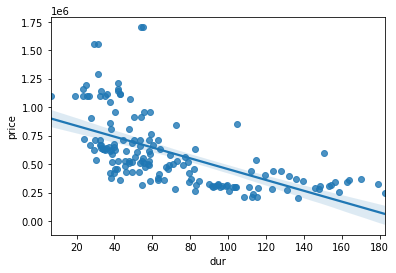

In [679]:
#do a scatter plot with a regression line
#as expected, the relationship between duration and price is negative: 
#in general, the shorter the journey time to Waterloo station, the more expensive the property
#but there are some notable exceptions
ax=sns.regplot(st.dur,st.price,label=st.TLC)
ax

<AxesSubplot:xlabel='durinv', ylabel='price'>

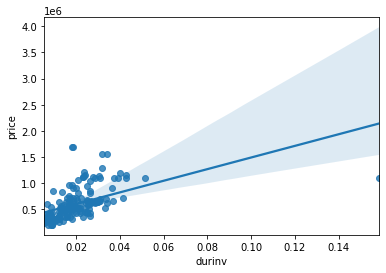

In [667]:
#if there is a proportional relationship in the sense that xy=c with c a constant, 
#then y should have a linear relationship with 1/x
st['durinv']=1/st.dur
sns.regplot(st.durinv,st.price,label=st.TLC)
#the chart below suggests that a linear relationship might be appropriate but there is an outlier with durinv>0.14

In [668]:
st.to_csv('st.csv',index=False)

In [669]:
#check which station this is
st[st.durinv>0.14]

,Station,Postcode,Latitude,Longitude,TLC,NLC,Owner,Entries and exits 2020,Entries and exits 2019,Entries and exits 2018,...,Interchanges 2005,pc1,dur,durn,price,pricen,ppmin,ppmin_n,Outstanding,durinv
0,Vauxhall,SW8 1SS,51.486188,-0.12289,VXH,5597,South Western Railway,19997264,21009688.0,20618840.0,...,0.0,SW8,6.309237,0.034477,1097312.5,0.645005,173921.596764,1.0,8.0,0.158498


In [670]:
#it is Vauxhall which we've seen earlier to be an outlier anyway

<AxesSubplot:xlabel='durinv', ylabel='price'>

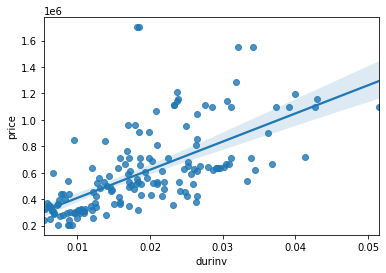

In [671]:
st_fil=st[st.durinv<0.14].copy().reset_index(drop=True)
p=sns.regplot(st_fil.durinv,st_fil.price,label=st_fil.TLC)
p
#This looks much better
#stations below the line and further to the right have a shorter commute time considering their price
#these are good candidates for places where people might like to live, of course before considering other factors

<h3>Affordability</h3>
Most 'normal' people have another constraint: affordability
Some of the stations score highly in terms of price per minute of commute but are still out of reach of many salary earners
To limit to more sensible results, set a budget of £500,000 as the maximum affordable house price
This is still quite high and can be refined if desired
This is for house prices in 2019 money, but inflation has been reasonably low since then

(7577942.440651299, 258607.30917913606)

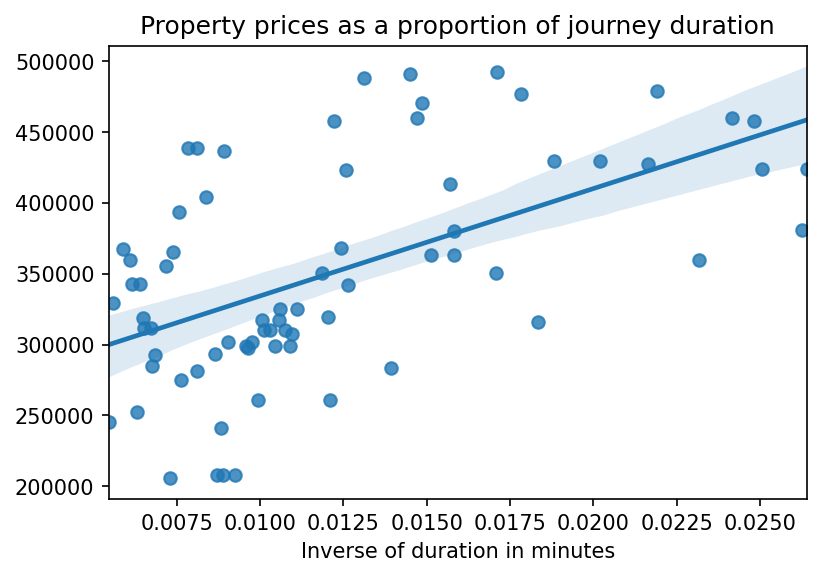

In [687]:
import matplotlib.pylab as plt
budget=500000
st_fil=st_fil[st_fil.price<=budget].copy().reset_index(drop=True)
fig=plt.figure(dpi=150)
p=sns.regplot(st_fil.durinv,st_fil.price,label=st_fil.TLC)
p.set_title('Property prices as a proportion of journey duration')
p.set_ylabel('')
p.set_xlabel('Inverse of duration in minutes')
plt.savefig('PP.png')
p

#get the intercept and slope for the line above
import scipy
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
slope,intercept

<h3>Good price/duration combination relative to peers</h3>
To get stations that are cheapest for their commute, compared to the others in the group, we want data points to be as low and to the right as possible. This is the same as moving the intercept down all the way, then back up again, and seeing which points come up first, second etc.<p>
Each datapoint can be defined by a unique value int2, an extra intercept, such that y=intercept+int2+slope*x<p>
solving: int2=y-intercept-slope*x<p>
int2 will be negative for data points below the line<p>
We want the most negative values as they will be furthest towards the bottom right<p>
Also we want them normalized in order to plot more usefully<p>

In [697]:
st_fil['int2']=st_fil.price-intercept-slope*st_fil.durinv
st_fil=st_fil.sort_values(by='int2').reset_index(drop=True)
mn,mx=min(st_fil.int2),max(st_fil.int2)
st_fil['int2_n']=(st_fil.int2-mn)/(mx-mn)
st_fil.to_csv('st_fil.csv')
q=st_fil[['Station','dur','price','Outstanding']].head(10)
q=q.round(0)
for i in ['dur','price','Outstanding']:
    q[i]=q[i].astype(int)
q=q.rename(columns={'dur':'Average journey in minutes','price':'Average sale price','Outstanding':'Number of Outstanding schools nearby'})
q.style.hide_index()

Station,Average journey in minutes,Average sale price,Number of Outstanding schools nearby
Fratton,108,208085,1
Portsmouth and Southsea,112,208085,1
Portsmouth Harbour,115,208085,1
Yeovil Pen Mill,137,205412,2
Southampton Airport Parkway,83,261178,7
Hilsea,113,241330,1
Basingstoke,55,316074,1
Andover,72,283650,0
Feltham,38,380629,2
Farnborough (Main),43,359768,4


In [675]:
#re-generate the map, but this time: 
#- plot price as a proportion of journey duration, and
#- plot number of schools as the fill colour, with more schools being better so they should be more green

#by inspection tweaked the location and zoom start to show a better picture
#focused on Grateley station as a fairly good centre point
t_lat,t_long=51.170060082874,-1.62077382846579
map_lon=folium.Map(location=[t_lat,t_long],zoom_start=8.45)

#create two color maps
w1=set(st_fil.int2_n)
colormap1=cm.LinearColormap(colors=['blue','red'],index=[min(w1),max(w1)])
w2=set(st_fil.Outstanding)
colormap2=cm.LinearColormap(colors=['red','green'],index=[min(w2),max(w2)])

# add markers to map
for lat,lng,ppm,out in zip(st_fil['Latitude'],st_fil['Longitude'],st_fil['int2_n'],st_fil['Outstanding']):
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=colormap1(ppm),
        fill=True,
        fill_color=colormap2(out),
        fill_opacity=1,
        parse_html=False).add_to(map_lon)
map_lon
#in the map below look for blue circles with green fills:
# - blue circles which are less expensive relative to their commute time, compared to others, and
# - green fills which have many Ofsted Outstanding schools nearby

<h3>Final results and discussion</h3>

In [698]:
#The chart suggests some promising stations in the Southampton area, also Reading and perhaps Farnborough
#To investigate, look at top 10 by number of Ofsted Outstanding schools and low price per commute time
q=st_fil.sort_values(by=['Outstanding','int2'],ascending=[False,True])[['Station','dur','price','Outstanding']].head(10)
q=q.round(0)
for i in ['dur','price','Outstanding']:
    q[i]=q[i].astype(int)
q=q.rename(columns={'dur':'Average journey in minutes','price':'Average sale price','Outstanding':'Number of Outstanding schools nearby'})
q.style.hide_index()

Station,Average journey in minutes,Average sale price,Number of Outstanding schools nearby
Southampton Airport Parkway,83,261178,7
Swaythling,101,261178,7
Southampton Central,93,310315,7
Reading,84,350578,7
St Denys,104,297648,6
Millbrook (Hants),97,310315,5
Earley,80,368230,5
Bagshot,68,459837,5
Farnborough (Main),43,359768,4
Ash Vale,59,350428,4
